In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
from sklearn.metrics import accuracy_score

# Reconocimiento de dígitos con KNN



Definir los path al ejecutable de python 3.6 y sus librerías,
de acuerdo al virtual env que estén corriendo.

In [23]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/gianluca/Documents/Metodos Numericos/tp2/bin/python (found version "3.8.2") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.8.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/gianluca/Documents/Metodos Numericos/github_g

In [2]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum


/home/gianluca/Documents/Metodos Numericos/github_grupal/metodos-num/tp2/notebooks
Python 3.8.5


## Explorando los datos

In [3]:
%load_ext autoreload
%autoreload 2

df_train = pd.read_csv("../data/train.csv")
df_train = df_train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


Es un csv, con columnas por cada pixel

In [4]:
# Uso values para mandar todo a arrays de numpy
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

X.shape, y.shape

((42000, 784), (42000, 1))

### Conjunto de development

In [5]:
X.shape

(42000, 784)

In [6]:
limit = int(0.8 * X.shape[0]) 

X_train, y_train = X[:limit], y[:limit]
X_val, y_val = X[limit:], y[limit:]

assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)

print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_val)} de validación")


Ahora tengo 33600 instancias de entrenamiento y 8400 de validación


In [7]:
def pca(alpha, train,validacion):
    pca= metnum.PCA(alpha)
    pca.fit(train)
    train_pca = pca.transform(train)
    val_pca = pca.transform(validacion)
    return train_pca, val_pca


In [8]:
def trainYvalidacion(k,alpha,X,y,X_val,y_val):
    X_pca, X_val_pca = pca(alpha,X,X_val)

    clf = metnum.KNNClassifier(k)
    clf.fit(X_pca, y)
    y_pred = clf.predict(X_val_pca)

    acc = accuracy_score(y_val, y_pred)
    print("Accuracy: {}".format(acc))
    recall    = recall_score(y_val, y_pred,average = None)
    precision = precision_score(y_val, y_pred, average=None)
    f1        = f1_score(y_val, y_pred, average = None)
    return acc,recall,precision, f1,y_pred

In [9]:
def numpy_to_csv(x,val,alpha,nset):
    df_x = pd.DataFrame(data=x)
    df_x.to_csv(f"transformaciones/{nset}_{alpha}_train.csv",index=False)
    df_val = pd.DataFrame(data=val)
    df_val.to_csv(f"transformaciones/{nset}_{alpha}_val.csv",index=False)

# Accuracy validacion simple

Buscamos las mejores parejas sobre un rango amplio de alpha y k , utilizando un split simple de 33600 instancias de entrenamiento y 8400 de validación.


In [14]:
alpha_max = 300
k_max = 150
salto_alpha = 5
salto_k = 2

alphas = [1] + [i*salto_alpha for i in range(1, int(alpha_max/salto_alpha) + 1)]
Ks = [1] + [i*salto_k for i in range(1,int(k_max/salto_k) + 1)]
#alphas , Ks

In [15]:
X_pca_max, X_val_pca_max = pca(alpha_max,X_train,X_val)

In [16]:
from timeit import default_timer as timer
start = timer()

col_alphas = []
col_k = []
accuracy = []

for alpha in alphas :
    
    X_pca, X_val_pca = X_pca_max[0:, 0:alpha], X_val_pca_max[0:, 0:alpha]
    
    for k in Ks :
        
        clf = metnum.KNNClassifier(k)
        clf.fit(X_pca, y_train)
        y_pred = clf.predict(X_val_pca)
        acc = accuracy_score(y_val, y_pred)
        
        #para armar dsp el dataframe
        accuracy.append(acc)
        col_alphas.append(alpha)
        col_k.append(k)

        
        
end = timer()
print(end - start)

KeyboardInterrupt: 

In [18]:
indmax = accuracy.index(max(accuracy))

best_alpha = col_alphas[indmax]
best_k = col_k[indmax]
print(f" Mejor (alpha, k): ({col_alphas[indmax]}, {col_k[indmax]})")
print(f"Accuracy : {accuracy[indmax]}" )

 Mejor (alpha, k): (50, 6)
Accuracy : 0.9736904761904762


In [60]:
dat = pd.DataFrame({"Alpha":col_alphas,"K":col_k,"Accuracy": accuracy})
dat,dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Alpha     2557 non-null   int64  
 1   K         2557 non-null   int64  
 2   Accuracy  2557 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 60.1 KB


(      Alpha   K  Accuracy
 0         1   1  0.256905
 1         1   2  0.242024
 2         1   4  0.276310
 3         1   6  0.277738
 4         1   8  0.281548
 ...     ...  ..       ...
 2552    165  88  0.938095
 2553    165  90  0.938095
 2554    165  92  0.937619
 2555    165  94  0.937619
 2556    165  96  0.937024
 
 [2557 rows x 3 columns],
 None)

In [27]:
#Guardar csv
dat.to_csv("exp_csv/validacionSimple.csv",index = False,header = True)


In [30]:
#Reshape DataFrame
val_simple = pd.read_csv("exp_csv/validacionSimple.csv")
val_simple_reshape = val_simple.pivot("Alpha","K","Accuracy")
val_simple_reshape

K,1,2,4,6,8,10,12,14,16,18,...,132,134,136,138,140,142,144,146,148,150
Alpha,,,,,,,,,,,,,,,,,,,,,
1,0.256905,0.242024,0.276310,0.277738,0.281548,0.282857,0.285000,0.289048,0.287262,0.286667,...,0.303690,0.304524,0.302857,0.304286,0.303095,0.305000,0.304048,0.305595,0.305595,0.305595
5,0.686786,0.688095,0.725952,0.738333,0.740952,0.748333,0.752976,0.754524,0.755357,0.755833,...,0.744643,0.745357,0.743929,0.743929,0.743095,0.742857,0.743333,0.742262,0.742857,0.742619
10,0.907857,0.901905,0.920476,0.922143,0.922857,0.923690,0.922857,0.921548,0.921190,0.919524,...,0.897976,0.897738,0.897500,0.897024,0.896429,0.896071,0.896310,0.895714,0.896190,0.895476
15,0.949405,0.942024,0.954048,0.952976,0.951786,0.951310,0.952143,0.951310,0.949524,0.950119,...,0.924048,0.923214,0.922619,0.922976,0.922143,0.922262,0.921667,0.921905,0.921548,0.920952
20,0.962738,0.955952,0.966190,0.965595,0.964643,0.963810,0.962500,0.962857,0.962500,0.960357,...,0.936548,0.935833,0.936190,0.935714,0.936190,0.935357,0.934405,0.934286,0.934167,0.933810
25,0.965119,0.963810,0.970357,0.970357,0.969405,0.967619,0.966071,0.966310,0.965238,0.965119,...,0.940952,0.940357,0.940000,0.939881,0.939405,0.939048,0.938690,0.938333,0.938095,0.937381
30,0.968214,0.964762,0.971667,0.971667,0.971310,0.970357,0.969643,0.969881,0.968690,0.967738,...,0.942500,0.942024,0.942143,0.941786,0.942143,0.941667,0.941667,0.941429,0.941310,0.940952
35,0.970476,0.965595,0.972143,0.972857,0.972619,0.971190,0.968929,0.968095,0.968571,0.967738,...,0.943571,0.942976,0.943095,0.942262,0.942500,0.942381,0.941905,0.941310,0.940952,0.940476
40,0.971310,0.966786,0.972381,0.972976,0.972024,0.970357,0.969524,0.968452,0.967381,0.967738,...,0.941786,0.941548,0.941429,0.940595,0.941071,0.940952,0.940833,0.940952,0.940476,0.939881


In [42]:
#Limpieza para visualizar mejor el heatmap

filtro = val_simple["Alpha"] > 10
val_simple= val_simple[filtro]
val_simple_reshape = val_simple.pivot("Alpha","K","Accuracy")
val_simple_reshape

K,1,2,4,6,8,10,12,14,16,18,...,132,134,136,138,140,142,144,146,148,150
Alpha,,,,,,,,,,,,,,,,,,,,,
15,0.949405,0.942024,0.954048,0.952976,0.951786,0.951310,0.952143,0.951310,0.949524,0.950119,...,0.924048,0.923214,0.922619,0.922976,0.922143,0.922262,0.921667,0.921905,0.921548,0.920952
20,0.962738,0.955952,0.966190,0.965595,0.964643,0.963810,0.962500,0.962857,0.962500,0.960357,...,0.936548,0.935833,0.936190,0.935714,0.936190,0.935357,0.934405,0.934286,0.934167,0.933810
25,0.965119,0.963810,0.970357,0.970357,0.969405,0.967619,0.966071,0.966310,0.965238,0.965119,...,0.940952,0.940357,0.940000,0.939881,0.939405,0.939048,0.938690,0.938333,0.938095,0.937381
30,0.968214,0.964762,0.971667,0.971667,0.971310,0.970357,0.969643,0.969881,0.968690,0.967738,...,0.942500,0.942024,0.942143,0.941786,0.942143,0.941667,0.941667,0.941429,0.941310,0.940952
35,0.970476,0.965595,0.972143,0.972857,0.972619,0.971190,0.968929,0.968095,0.968571,0.967738,...,0.943571,0.942976,0.943095,0.942262,0.942500,0.942381,0.941905,0.941310,0.940952,0.940476
40,0.971310,0.966786,0.972381,0.972976,0.972024,0.970357,0.969524,0.968452,0.967381,0.967738,...,0.941786,0.941548,0.941429,0.940595,0.941071,0.940952,0.940833,0.940952,0.940476,0.939881
45,0.971071,0.967857,0.972857,0.972381,0.971190,0.971786,0.970714,0.968929,0.968095,0.967143,...,0.940952,0.940714,0.940238,0.940119,0.939762,0.938810,0.938690,0.938810,0.937976,0.938333
50,0.971071,0.967500,0.973452,0.973690,0.971786,0.971071,0.970476,0.969762,0.967857,0.966071,...,0.938333,0.938214,0.937857,0.938333,0.937738,0.937619,0.937619,0.937381,0.937143,0.937143
55,0.970595,0.965476,0.972619,0.973333,0.971548,0.971071,0.970952,0.968690,0.968095,0.966905,...,0.938214,0.938214,0.938095,0.937738,0.937738,0.937619,0.937143,0.936786,0.936786,0.936786


Text(0.5, 1.0, 'Validacion Simple ')

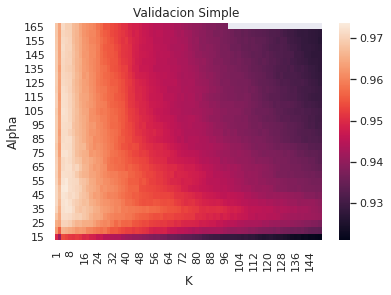

In [43]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
hmap = sns.heatmap(val_simple_reshape)    #,annot = True)#,cmap = "YlGnBu") # colores de mapa claros
hmap.invert_yaxis()
plt.title("Validacion Simple ")
#plt.savefig("exp_csv/plots/validacionSimple_heatmap.png")

# Cross Validation

Extraemos de la validacion simple los parametros de las mejores 30 parejas para luego hacer CV con ellas.

In [74]:
val_simple.sort_values(by=['Accuracy'],ascending = False).head(80)

,Alpha,K,Accuracy
763,50,6,0.973690
762,50,4,0.973452
839,55,6,0.973333
611,40,6,0.972976
686,45,4,0.972857
...,...,...,...
1979,130,6,0.970595
836,55,1,0.970595
532,35,1,0.970476
1676,110,8,0.970476


In [102]:
mejores_k = val_simple.sort_values(by=['Accuracy'],ascending = False).head(30)["K"].unique()
mejores_k = list(map(int, mejores_k))
mejores_k.sort()
len(mejores_k)

4

In [101]:
mejores_alphas = val_simple.sort_values(by=['Accuracy'],ascending = False).head(30)["Alpha"].unique()
mejores_alphas = list(mejores_alphas)
mejores_alphas.sort()
len(mejores_alphas)


15

In [82]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, f1_score, cohen_kappa_score, precision_score

def work(X, y, clf, k):

    accuracy = []
    recall = np.zeros(10)
    precision = np.zeros(10)
    f1 = np.zeros(10)

    kf = KFold(n_splits=k)
    i = 1
    for train_index, test_index in kf.split(X):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracy.append(accuracy_score(y_test, y_pred))
        recall    += recall_score(y_test, y_pred,average = None)
        precision += precision_score(y_test, y_pred, average=None)
        f1        += f1_score(y_test, y_pred, average = None)
        
        i += 1
    
    recall /= k
    precision /= k
    f1 /= k
    return np.mean(accuracy),recall,precision, f1

# HACER SHUFFLE EN DATA y ANALIZAR TRAIN SET

In [64]:
X.shape,y.shape

((42000, 784), (42000, 1))

In [89]:
idx

array([24337, 23456, 21772, ...,  9490, 25196,  2004])

In [90]:
#Mezclo la data original
idx = np.random.permutation(len(X))
X,y = X[idx], y[idx]
X.shape,y.shape

((42000, 784), (42000, 1))

In [91]:
limit = int(0.8 * X.shape[0]) 

X_train, y_train = X[:limit], y[:limit]
X_val, y_val = X[limit:], y[limit:]

assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)

print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_val)} de validación")

Ahora tengo 33600 instancias de entrenamiento y 8400 de validación


In [92]:
X_pca_max, X_val_pca_max = pca(max(mejores_alphas),X_train,X_val)
print(f"Max alpha = {max(mejores_alphas)}")

Max alpha = 115


In [93]:
kfold = 10
X_pca_max.shape,y_train.shape

((33600, 115), (33600, 1))

In [94]:
cantidad_parejas = len(mejores_alphas)* len(mejores_k)
cantidad_parejas

60

In [95]:
from timeit import default_timer as timer
start = timer()

info_parejas = []
recall_cv = np.zeros((cantidad_parejas,10))
precision_cv = np.zeros((cantidad_parejas,10))
f1_cv = np.zeros((cantidad_parejas,10))


col_k = []
col_alphas = []
accuracy = []

i = 0
for alpha in mejores_alphas :
    
    X_pca = X_pca_max[0:, 0:alpha]
    
    for k in mejores_k :
        
        clf = metnum.KNNClassifier(k)
        info = work(X_pca, y_train, clf, kfold)
        info_parejas.append(info)
        
        recall_cv[i] = info[1]
        precision_cv[i] = info[2]
        f1_cv[i] = info[3]
        
        #para armar dsp el heatmap
        accuracy.append(info[0])
        col_alphas.append(alpha)
        col_k.append(k)
    
    if(i%5 == 0):
        print(f"Iteracion numero :{i}")
    i += 1
        
        
end = timer()
print(end - start)

Iteracion numero :0
Iteracion numero :5
Iteracion numero :10
5165.833575152006


In [96]:
rec = pd.DataFrame(data = recall_cv)
rec.insert(0, "K", col_k , True) 
rec.insert(0, "Alpha", col_alphas , True) 
rec.to_csv("exp_csv/recall_cv.csv",index = True,header = True)

preci = pd.DataFrame(data = precision_cv)
preci.insert(0, "K", col_k , True) 
preci.insert(0, "Alpha", col_alphas , True) 
preci.to_csv("exp_csv/precision_cv.csv",index = True,header = True)


f1 = pd.DataFrame(data = f1_cv)
f1.insert(0, "K", col_k , True) 
f1.insert(0, "Alpha", col_alphas , True) 
f1.to_csv("exp_csv/f1_cv.csv",index = True,header = True)

In [106]:
#PRIMEROS VALORES DE LAS METRICAS
display(rec.head())
display(preci.head())
display(f1.head())

,Alpha,K,0,1,2,3,4,5,6,7,8,9
0,35,4,0.989769,0.991960,0.962505,0.952059,0.956247,0.966031,0.990069,0.969207,0.954720,0.962617
1,35,6,0.990312,0.992375,0.959837,0.954396,0.955638,0.964351,0.990076,0.968927,0.951458,0.964999
2,35,8,0.990960,0.992385,0.958685,0.953093,0.954944,0.964449,0.990054,0.968626,0.950200,0.963760
3,35,10,0.990935,0.992934,0.958949,0.953570,0.956264,0.963837,0.989759,0.970017,0.946002,0.963164
4,40,4,0.990330,0.993198,0.958700,0.956374,0.956260,0.962904,0.990036,0.968587,0.945095,0.963112


,Alpha,K,0,1,2,3,4,5,6,7,8,9
0,35,4,0.986753,0.974664,0.980404,0.973820,0.981822,0.965596,0.970450,0.965503,0.970363,0.929586
1,35,6,0.985013,0.973141,0.979169,0.973247,0.983417,0.965940,0.968405,0.964449,0.973711,0.930746
2,35,8,0.984986,0.970633,0.980869,0.974048,0.984937,0.966608,0.968685,0.962236,0.972381,0.927620
3,35,10,0.984767,0.969911,0.980532,0.972197,0.982829,0.963741,0.970066,0.962050,0.975098,0.929841
4,40,4,0.983845,0.968920,0.982613,0.972508,0.982852,0.964685,0.970082,0.960664,0.975655,0.929135


,Alpha,K,0,1,2,3,4,5,6,7,8,9
0,35,4,0.988250,0.983206,0.971307,0.962777,0.968820,0.965779,0.980103,0.967329,0.962377,0.945763
1,35,6,0.987643,0.982637,0.969330,0.963670,0.969266,0.965087,0.979058,0.966666,0.962375,0.947508
2,35,8,0.987956,0.981361,0.969579,0.963421,0.969653,0.965460,0.979194,0.965410,0.961108,0.945292
3,35,10,0.987831,0.981258,0.969569,0.962760,0.969315,0.963752,0.979753,0.965998,0.960260,0.946175
4,40,4,0.987064,0.980882,0.970454,0.964331,0.969322,0.963735,0.979905,0.964586,0.960052,0.945761


In [99]:
dfCV = pd.DataFrame({"Alpha":col_alphas,"K":col_k,"Accuracy": accuracy})
dfCV.to_csv("exp_csv/CrossValidation.csv",index = True,header = True)
dfCV

,Alpha,K,Accuracy
0,35,4,0.971161
1,35,6,0.972202
2,35,8,0.971071
3,35,10,0.969792
4,40,4,0.971726
5,40,6,0.972173
6,40,8,0.970923
7,40,10,0.969554
8,45,4,0.970060
9,45,6,0.971964


In [108]:
indmax = accuracy.index(max(accuracy))
bestAlpha_cv = col_alphas[indmax]
bestK_cv = col_k[indmax]
print(f"Mejor pareja de cross validation :(Alpha,k) = {bestAlpha_cv}, {bestK_cv}" )

Mejor pareja de cross validation :(Alpha,k) = 35, 6


# Train y test con la mejor pareja de CV


In [112]:
acc,recall,precision,f1,pred = trainYvalidacion(bestK_cv,bestAlpha_cv,X_train,y_train,X_val,y_val)

Accuracy: 0.9707142857142858


In [114]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val,pred,normalize = "true")
#PONEMOS CEROS EN LA DIAGONAL PARA VISUALIZAR MEJOR EL HEATPMAP
np.fill_diagonal(cm, 0, wrap=False)

Text(0.5, 1.0, 'Confusion Matrix de Mejor pareja de CV')

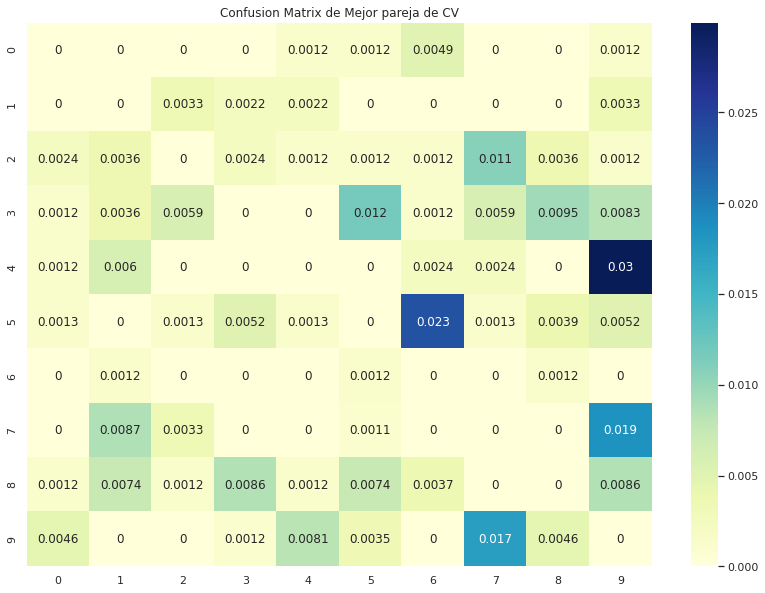

In [128]:
plt.figure(figsize=(14,10))
sns.heatmap(cm,cmap = "YlGnBu",annot = True)
plt.title("Confusion Matrix de Mejor pareja de CV")

# Prestar atencion a la escala de cada ploteo , se encuentran de tal manera de modo que se visualicen mejor por separado.

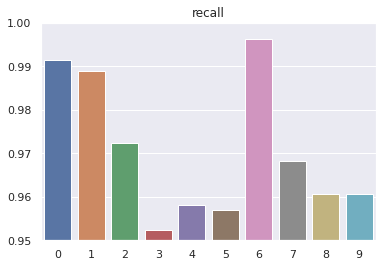

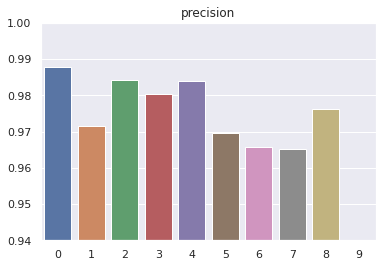

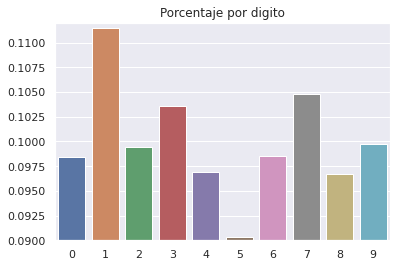

In [130]:
import matplotlib.pyplot as plt
ejex = [i for i in range(10)]
sns.barplot(x = ejex , y = recall)
plt.ylim(0.95, 1)
plt.title("recall")
plt.show()
sns.barplot(x = ejex , y = precision)
plt.ylim(0.94, 1)
plt.title("precision")
plt.show()
yy = df_train["label"].value_counts(normalize=True).sort_index().to_list()
sns.barplot(x = ejex , y = yy)
plt.ylim(0.09, 0.112)
plt.title("Porcentaje por digito")
plt.show()

# Balanceo

In [131]:
cant_por_digito = df_train[:33600]["label"].value_counts(normalize=False).sort_index().to_list()
cant_cincos = cant_por_digito[5]
cant_cincos ,cant_por_digito

(3048, [3280, 3734, 3376, 3469, 3261, 3048, 3306, 3517, 3261, 3348])

In [132]:
X_balanceado = np.zeros((cant_cincos*10,X_train.shape[1]))
cant_balanceado = 10*[0]
cant_balanceado

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [133]:
j = 0
for i in range(X_train.shape[0]) :
    if(cant_balanceado[y_train[i][0]] < cant_cincos):
        X_balanceado[j] = X_train[i]
        cant_balanceado[y_train[i][0]] += 1
        j+=1
    

In [134]:
cant_balanceado

[3048, 3048, 3048, 3048, 3048, 3027, 3048, 3048, 3048, 3048]

In [135]:
acc,recall,precision,f1,pred = trainYvalidacion(bestK_cv,bestAlpha_cv,X_balanceado,y_train,X_val,y_val)

Accuracy: 0.9686904761904762


# Prestar atencion a la escala de cada ploteo , se encunetran de tal manera de modo que se visualicen mejor por separado.

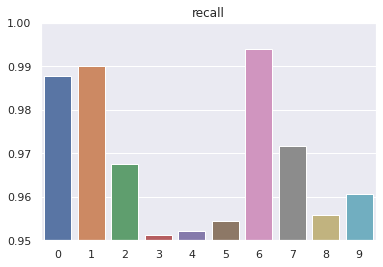

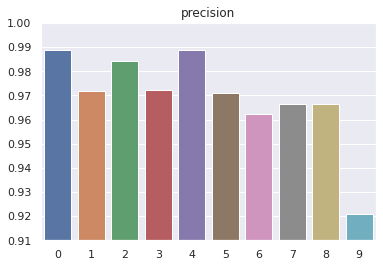

In [140]:
import matplotlib.pyplot as plt
ejex = [i for i in range(10)]
sns.barplot(x = ejex , y = recall)
plt.ylim(0.95, 1)
plt.title("recall")
plt.show()
sns.barplot(x = ejex , y = precision)
plt.ylim(0.91, 1)
plt.title("precision")
plt.show()

# # Pruebas 2d y 3d

In [56]:
X_3d, X_val3d = pca(3,X_train,X_val)

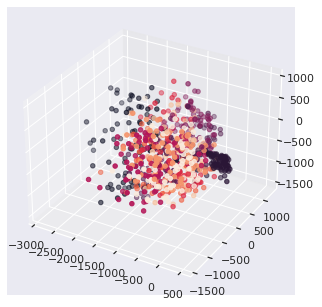

In [50]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random


fig = pyplot.figure()
ax = Axes3D(fig)

sequence_containing_x_vals = X_3d[:,0]
sequence_containing_y_vals = X_3d[:,1]
sequence_containing_z_vals = X_3d[:,2]

#random.shuffle(sequence_containing_x_vals)
#random.shuffle(sequence_containing_y_vals)
#random.shuffle(sequence_containing_z_vals)

ax.scatter(sequence_containing_x_vals, sequence_containing_y_vals, sequence_containing_z_vals,c = y_train)
pyplot.show()

In [55]:
X_2d, X_val2d = pca(2,X_train,X_val)

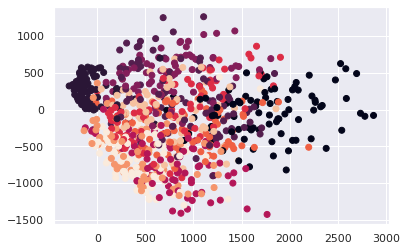

In [55]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random


fig = pyplot.figure()

sequence_containing_x_vals = X_2d[:,0]
sequence_containing_y_vals = X_2d[:,1]

#random.shuffle(sequence_containing_x_vals)
#random.shuffle(sequence_containing_y_vals)
#random.shuffle(sequence_containing_z_vals)

plt.scatter(sequence_containing_x_vals, sequence_containing_y_vals, c = y_train)
pyplot.show()